# Siamese BERT-networks for semantic searching

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import numpy as np
from datasets import load_dataset
import torch

from sentence_transformers import SentenceTransformer, util, InputExample, losses, evaluation
from transformers import pipeline

from random import sample, seed, shuffle
from torch.utils.data import DataLoader

f:\__ing\llming_1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_max_input_size(model):
    from transformers import BertConfig

    # Load the configuration of the pre-trained BERT model
    config = BertConfig.from_pretrained(model)

    # Get the maximum input size
    max_input_size = config.max_position_embeddings
    return max_input_size - 2 # CLS & SEP

get_max_input_size('deepset/roberta-base-squad2')

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


512

In [3]:
PERSON = 'Mohammed Elhamamsy'

google_html = BeautifulSoup(
    requests.get(
        f'https://www.google.com/search?hl=en&q={PERSON}'
    ).text
).get_text().split(f"_".join(PERSON.split()))[-1][:1024]

nlp = pipeline(
    task='question-answering',
    model='deepset/roberta-base-squad2',
    tokenizer='deepset/roberta-base-squad2',
    max_length=10
)

print(google_html)
nlp(f'Who is {PERSON}?', google_html)

Mohammed Elhamamsy - Google SearchGoogle×Please click here if you are not redirected within a few seconds.    AllImagesNewsVideos Maps Books Search tools    Any timeAny timePast hourPast 24 hoursPast weekPast monthPast yearAll resultsAll resultsVerbatimIncluding results for Mohamed ElhamamsySearch only for Mohammed ElhamamsyMohammed Elhamamsy - Data Scientist - SAS - LinkedIneg.linkedin.com › melhamamsyA data scientist with a strong background in Mathematics, proficiency in Python language, in-depth knowledge of Statistics and Machine Learning, ...Mohamed Elhamamsy | LinkedIneg.linkedin.com › mohamed-elhamamsy-19950425“Mohamed is a dedicated person seeking perfection at every task he has the ability to multi-task and give a new solution for any problem, He is Organized, and ...Mohamed Elhamamsy, DDS - Harbor Health Serviceswww.hhsi.us › providers › mohamed-elhamamsyMohamed Elhamamsy, DDS. Job Title: Dentist Specialty/Focus: General Dentistry School of Degree(s): Alexandria University, 

{'score': 0.34349820017814636,
 'start': 347,
 'end': 361,
 'answer': 'Data Scientist'}

In [4]:
text = urlopen('https://www.gutenberg.org/cache/epub/10834/pg10834.txt').read().decode()

documents = list(
    filter(
        lambda x: len(x)>100, text.split('\r\n\r\n')
    )
)
documents = np.array(documents)

print(f'There are {len(documents)} documents/paragraphs')

There are 70 documents/paragraphs


In [5]:
bi_encoder = SentenceTransformer('msmarco-distilbert-base-v4')
bi_encoder.max_seq_length = 256

bi_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [6]:
document_embeddings = bi_encoder.encode(
    documents, convert_to_tensor=True, show_progress_bar=True
)

document_embeddings.shape

Batches: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


torch.Size([70, 768])

In [7]:
QUESTION = 'How many horns does a flea have?'

question_embedding = bi_encoder.encode(QUESTION, convert_to_tensor=True)
question_embedding.shape

torch.Size([768])

In [8]:
hits = util.semantic_search(question_embedding,document_embeddings,top_k=3)[0]
hits

[{'corpus_id': 15, 'score': 0.4899492859840393},
 {'corpus_id': 20, 'score': 0.24793772399425507},
 {'corpus_id': 22, 'score': 0.18478833138942719}]

In [9]:
print(f"Question: {QUESTION}\n")

for i, hit in enumerate(hits):
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}\n\n')

Question: How many horns does a flea have?

Document 1 Cos_Sim 0.490:

When examined by a microscope, the flea is a pleasant object. The body
is curiously adorned with a suit of polished armour, neatly jointed, and
beset with a great number of sharp pins almost like the quills of a
porcupine: it has a small head, large eyes, two horns, or feelers, which
proceed from the head, and four long legs from the breast; they are very
hairy and long, and have several joints, which fold as it were one
within another.


Document 2 Cos_Sim 0.248:

The Chego is a very small animal, about one fourth the size of a common
flea: it is very troublesome, in warm climates, to the poor blacks, such
as go barefoot, and the slovenly: it penetrates the skin, under which it
lays a bunch of eggs, which swell to the bigness of a small pea.


Document 3 Cos_Sim 0.185:


This is one of the largest of the insect tribe. It is met with in
different countries, and of various sizes, from two or three inches to
nearly a 

In [10]:
nlp(QUESTION, str(documents[hits[0]['corpus_id']]))

{'score': 0.8524741530418396, 'start': 259, 'end': 262, 'answer': 'two'}

In [11]:
# Load dataset to pretrain the open-book QA system:
training_qa = load_dataset('adversarial_qa','adversarialQA',split='train')

good_training_data = []
bad_training_data = []

last_example = None
for example in training_qa:
    if last_example and (example['context'] != last_example['context']):
        bad_training_data.append((example['question'], example['context'], 0.0))

    good_training_data.append((example['question'], example['context'], 1.0))
    last_example = example

In [12]:
len(good_training_data), len(bad_training_data)

(30000, 2647)

In [13]:
seed(42)

sampled_training_data = sample(good_training_data, 500) + sample(bad_training_data, 500)

shuffle(sampled_training_data)

training_index = int(.8 * len(sampled_training_data))

In [14]:
train_examples = [InputExample(
    texts=t[:2], label=t[2]
) for t in sampled_training_data[:training_index]]
train_examples[0].__dict__

{'guid': '',
 'texts': ('What changed after the eigth century?',
  'There is disagreement about the origin of the term, but general consensus that "cardinalis" from the word cardo (meaning \'pivot\' or \'hinge\') was first used in late antiquity to designate a bishop or priest who was incorporated into a church for which he had not originally been ordained. In Rome the first persons to be called cardinals were the deacons of the seven regions of the city at the beginning of the 6th century, when the word began to mean “principal,” “eminent,” or "superior." The name was also given to the senior priest in each of the "title" churches (the parish churches) of Rome and to the bishops of the seven sees surrounding the city. By the 8th century the Roman cardinals constituted a privileged class among the Roman clergy. They took part in the administration of the church of Rome and in the papal liturgy. By decree of a synod of 769, only a cardinal was eligible to become pope. In 1059, during th

In [15]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(bi_encoder)

In [18]:
sentences1, sentences2, scores = zip(*sampled_training_data[training_index:])

evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1=sentences1,sentences2=sentences2,scores=scores)

In [19]:
bi_encoder.evaluate(evaluator)

-0.06989261842320198

In [20]:
bi_encoder.fit(
    train_objectives=[(train_dataloader,train_loss)],
    output_path='ir/results',
    epochs=2,
    evaluator=evaluator
)

Epoch: 100%|██████████| 2/2 [05:14<00:00, 157.14s/it]


In [21]:
bi_encoder.evaluate(evaluator=evaluator)

-0.06971940251632912

In [22]:
finetuned_bi_encoder = SentenceTransformer('ir/results/')

In [23]:
document_embeddings = finetuned_bi_encoder.encode(documents, convert_to_tensor=True, show_progress_bar=True)
question_embedding = finetuned_bi_encoder.encode(QUESTION, convert_to_tensor=True)

hits = util.semantic_search(question_embedding, document_embeddings, top_k=3)[0]


print(f"Question: {QUESTION}\n")

for i, hit in enumerate(hits):
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}\n\n')

Batches: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

Question: How many horns does a flea have?

Document 1 Cos_Sim 0.491:

When examined by a microscope, the flea is a pleasant object. The body
is curiously adorned with a suit of polished armour, neatly jointed, and
beset with a great number of sharp pins almost like the quills of a
porcupine: it has a small head, large eyes, two horns, or feelers, which
proceed from the head, and four long legs from the breast; they are very
hairy and long, and have several joints, which fold as it were one
within another.


Document 2 Cos_Sim 0.249:

The Chego is a very small animal, about one fourth the size of a common
flea: it is very troublesome, in warm climates, to the poor blacks, such
as go barefoot, and the slovenly: it penetrates the skin, under which it
lays a bunch of eggs, which swell to the bigness of a small pea.


Document 3 Cos_Sim 0.186:


This is one of the largest of the insect tribe. It is met with in
different countries, and of various sizes, from two or three inches to
nearly a 

# Teaching GPT Multiple tasks at once with prompt engineering

In [29]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
        GPT2Tokenizer

import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt

In [25]:
reviews = pd.read_csv('./data/reviews.csv')
reviews

,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4
...,...,...,...
96507,We need this for a recipe my wife is intereste...,a-ok,4
96508,This product is great. Gives you so much ener...,Great Cafe Latte,5
96509,My only complaint is that there's so much of i...,Very large ground spice jars.,5
96510,Great for sesame chicken..this is a good if no...,Will not do without,5


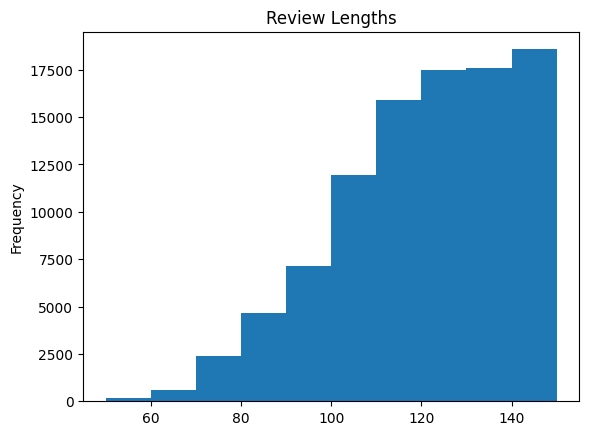

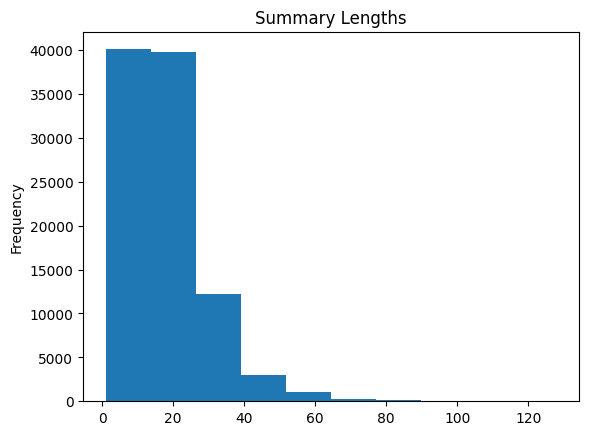

In [31]:
reviews['Text'].str.len().plot(kind='hist', title='Review Lengths'); plt.show()
reviews['Summary'].str.len().plot(kind='hist', title='Summary Lengths'); plt.show()

In [39]:
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 25)]
reviews['Sentiment'] = reviews['Score'].map(
    lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative'
)

reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000)).reset_index(drop=True)
reviews

,Text,Summary,Score,Sentiment,sentiment_task,summarize_task
0,I found Jeremiah's Pick Kona Blend lacking fla...,Kona Blend lacks flavor.,2,negative,Sentiment Task\nReview:I found Jeremiah's Pick...,Summarize Task\nReview:I found Jeremiah's Pick...
1,my cat only looks at it if i throw it around. ...,Not for my cat,2,negative,Sentiment Task\nReview:my cat only looks at it...,Summarize Task\nReview:my cat only looks at it...
2,Buy something else. Hydrogenated fats are an u...,Hydrogenated oil,1,negative,Sentiment Task\nReview:Buy something else. Hyd...,Summarize Task\nReview:Buy something else. Hyd...
3,This coffee tastes like any other. I highly do...,Not worth it.,1,negative,Sentiment Task\nReview:This coffee tastes like...,Summarize Task\nReview:This coffee tastes like...
4,I just don't like the taste...Other people mig...,not very good!,1,negative,Sentiment Task\nReview:I just don't like the t...,Summarize Task\nReview:I just don't like the t...
...,...,...,...,...,...,...
2995,"Love this stuff. I use it as ""creamer"" in my ...",Some low-caloire sin,5,positive,Sentiment Task\nReview:Love this stuff. I use...,Summarize Task\nReview:Love this stuff. I use...
2996,Dark Chocolate cookies taste great! I have ju...,Great Taste!,5,positive,Sentiment Task\nReview:Dark Chocolate cookies ...,Summarize Task\nReview:Dark Chocolate cookies ...
2997,"Great service, as always, from Amazon.<br />I ...",Excellent Maple Syrup!,5,positive,"Sentiment Task\nReview:Great service, as alway...","Summarize Task\nReview:Great service, as alway..."
2998,"No filler ingredients, could be dryer but the ...",Our dog loves it,5,positive,"Sentiment Task\nReview:No filler ingredients, ...","Summarize Task\nReview:No filler ingredients, ..."


In [40]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

In [45]:
reviews['sentiment_task'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN + ' ' + reviews['Sentiment']
reviews['summarize_task'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN + ' ' + reviews['Summary']

In [46]:
print(reviews['sentiment_task'][0])
print(reviews['summarize_task'][0])

Sentiment Task
Review: I found Jeremiah's Pick Kona Blend lacking flavor. I tried every trick I know to bring out all the taste it had but still found it weak.
Sentiment: negative
Summarize Task
Review: I found Jeremiah's Pick Kona Blend lacking flavor. I tried every trick I know to bring out all the taste it had but still found it weak.
Summarize: Kona Blend lacks flavor.


In [47]:
train_examples = reviews['summarize_task'].tolist() + reviews['sentiment_task'].tolist()

In [49]:
multi_task_df = pd.DataFrame({'text':train_examples})
multi_task_df = multi_task_df.sample(frac=1, replace=False).reset_index(drop=True)

multi_task_df

,text
0,"Sentiment Task\nReview: Strong, salty taste wi..."
1,Summarize Task\nReview: A unique flavor that m...
2,Sentiment Task\nReview: I usually like this br...
3,Sentiment Task\nReview: I lived for my weekly ...
4,Sentiment Task\nReview: These are not sturdy e...
...,...
5995,Sentiment Task\nReview: We just bought Tassimo...
5996,Sentiment Task\nReview: came with an expiratio...
5997,Summarize Task\nReview: i ordered mint chocola...
5998,Summarize Task\nReview: Arrived slightly thawe...


In [50]:
data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)
data = data.train_test_split(train_size=.8)

Map: 100%|██████████| 6000/6000 [00:05<00:00, 1090.16 examples/s]


In [51]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [52]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [55]:
training_args = TrainingArguments(
    output_dir='./gpt2_multitask',
    overwrite_output_dir=True, 
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32, # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
) 

trainer.evaluate()

100%|██████████| 38/38 [00:05<00:00,  6.96it/s]


{'eval_loss': 5.002038478851318,
 'eval_runtime': 7.7983,
 'eval_samples_per_second': 153.88,
 'eval_steps_per_second': 4.873}

In [56]:
trainer.train()

 17%|█▋        | 50/300 [00:20<01:47,  2.33it/s]

{'loss': 3.4107, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.33}


 33%|███▎      | 100/300 [01:58<09:11,  2.76s/it]

{'loss': 2.9692, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.67}


 50%|█████     | 150/300 [04:44<05:40,  2.27s/it]

{'loss': 2.892, 'learning_rate': 2.5e-05, 'epoch': 1.0}



 50%|█████     | 150/300 [05:15<05:40,  2.27s/it]

{'eval_loss': 2.7177278995513916, 'eval_runtime': 30.6851, 'eval_samples_per_second': 39.107, 'eval_steps_per_second': 1.238, 'epoch': 1.0}


 67%|██████▋   | 200/300 [08:21<06:06,  3.67s/it]

{'loss': 2.7966, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.33}


 83%|████████▎ | 250/300 [11:10<02:36,  3.14s/it]

{'loss': 2.7548, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.67}


100%|██████████| 300/300 [13:47<00:00,  3.02s/it]

{'loss': 2.7371, 'learning_rate': 0.0, 'epoch': 2.0}



100%|██████████| 300/300 [14:23<00:00,  3.02s/it]

{'eval_loss': 2.66652250289917, 'eval_runtime': 36.028, 'eval_samples_per_second': 33.307, 'eval_steps_per_second': 1.055, 'epoch': 2.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
100%|██████████| 300/300 [14:33<00:00,  2.91s/it]

{'train_runtime': 873.3995, 'train_samples_per_second': 10.992, 'train_steps_per_second': 0.343, 'train_loss': 2.926726989746094, 'epoch': 2.0}


TrainOutput(global_step=300, training_loss=2.926726989746094, metrics={'train_runtime': 873.3995, 'train_samples_per_second': 10.992, 'train_steps_per_second': 0.343, 'train_loss': 2.926726989746094, 'epoch': 2.0})

In [57]:
trainer.evaluate()

100%|██████████| 38/38 [00:35<00:00,  1.06it/s]


{'eval_loss': 2.66652250289917,
 'eval_runtime': 36.2401,
 'eval_samples_per_second': 33.112,
 'eval_steps_per_second': 1.049,
 'epoch': 2.0}

In [58]:
trainer.save_model()

In [59]:
generator = pipeline(
    task='text-generation',
    model=GPT2LMHeadModel.from_pretrained('./gpt2_multitask'),
    tokenizer=tokenizer
)

In [61]:
text_sample, score, summary = reviews.sample(1)[['Text','Sentiment','Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

These are great, they taste like the best apple pie you have ever eaten.  At 70 calories they are a healthy and low fat for adults too!
positive
Incredible!


31

In [62]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [63]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 1):
    print(generated_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
f:\__ing\llming_1\.venv\lib\site-packages\transformers\generation\utils.py:1281: UserWarning: Input length of input_ids is 41, but `max_length` is set to 32. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Sentiment Task
Review: These are great, they taste like the best apple pie you have ever eaten.  At 70 calories they are a healthy and low fat for adults too!
Sentiment: positive


In [64]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('--------------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: These are great, they taste like the best apple pie you have ever eaten.  At 70 calories they are a healthy and low fat for adults too!
Summarize: Great! Great!
Summarize
--------------
Summarize Task
Review: These are great, they taste like the best apple pie you have ever eaten.  At 70 calories they are a healthy and low fat for adults too!
Summarize: Great apple pie made with apple! 
--------------
Summarize Task
Review: These are great, they taste like the best apple pie you have ever eaten.  At 70 calories they are a healthy and low fat for adults too!
Summarize: A good mix to mix for adults!
--------------
